In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install imbalanced-learn


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Exercise-Recommender/new/mental/Mental_Health_Lifestyle_Dataset.csv')

In [ ]:
df

,Country,Age,Gender,Exercise Level,Diet Type,Sleep Hours,Stress Level,Mental Health Condition,Work Hours per Week,Screen Time per Day (Hours),Social Interaction Score,Happiness Score
0,Brazil,48,Male,Low,Vegetarian,6.3,Low,NaN,21,4.0,7.8,6.5
1,Australia,31,Male,Moderate,Vegan,4.9,Low,PTSD,48,5.2,8.2,6.8
2,Japan,37,Female,Low,Vegetarian,7.2,High,NaN,43,4.7,9.6,9.7
3,Brazil,35,Male,Low,Vegan,7.2,Low,Depression,43,2.2,8.2,6.6
4,Germany,46,Male,Low,Balanced,7.3,Low,Anxiety,35,3.6,4.7,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Japan,57,Female,Moderate,Balanced,7.0,High,Depression,29,4.4,9.7,5.9
2996,Australia,27,Male,Low,Junk Food,7.1,Low,NaN,47,7.4,6.3,9.9
2997,Australia,42,Male,Moderate,Balanced,6.0,High,Depression,23,3.9,5.2,4.1
2998,Australia,25,Male,High,Keto,5.7,Low,Anxiety,51,4.3,5.9,4.1


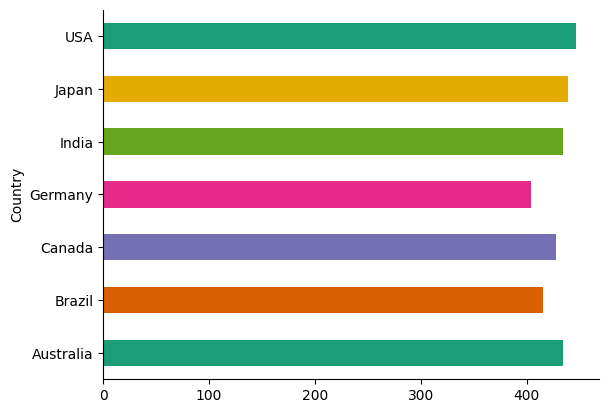

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# df.drop(columns=['Country'], inplace=True)

df['Target'] = df['Mental Health Condition'].apply(lambda x: 0 if x == 'None' else 1)
numeric_cols = ['Age', 'Sleep Hours', 'Work Hours per Week', 'Screen Time per Day (Hours)',
                'Social Interaction Score', 'Happiness Score']

for col in numeric_cols:
    Q1 = df[col].quantile(0.01)
    Q3 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], Q1, Q3)

X = df.drop(['Mental Health Condition', 'Target'], axis=1)
y = df['Target']

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[600]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       600

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
pip install gradio

In [ ]:
import joblib

# After model.fit(...)
model.feature_names = X.columns.tolist()  # Store manually
joblib.dump(model, 'mental_health_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


In [ ]:
import gradio as gr
import joblib
import pandas as pd

# Load model and scaler
model = joblib.load("mental_health_model.pkl")
scaler = joblib.load("scaler.pkl")

def predict_mh(age, gender, exercise, diet, sleep, stress, work_hours, screen_time, social_score, happiness):
    try:
        # Build input dictionary
        input_dict = {
            'Age': [age],
            'Sleep Hours': [sleep],
            'Work Hours per Week': [work_hours],
            'Screen Time per Day (Hours)': [screen_time],
            'Social Interaction Score': [social_score],
            'Happiness Score': [happiness],

            # One-hot encoded fields
            'Gender_Male': [1 if gender == "Male" else 0],
            'Gender_Other': [1 if gender == "Other" else 0],
            'Exercise Level_Moderate': [1 if exercise == "Moderate" else 0],
            'Exercise Level_Strong': [1 if exercise == "Strong" else 0],
            'Diet Type_Vegan': [1 if diet == "Vegan" else 0],
            'Diet Type_Vegetarian': [1 if diet == "Vegetarian" else 0],
            'Stress Level_Medium': [1 if stress == "Medium" else 0],
            'Stress Level_High': [1 if stress == "High" else 0],
        }

        df_input = pd.DataFrame(input_dict)

        # Add missing columns with zeros
        for col in model.feature_names:
            if col not in df_input.columns:
                df_input[col] = 0
        df_input = df_input[model.feature_names]

        # Scale input
        scaled_input = scaler.transform(df_input)

        # Predict
        prediction = model.predict(scaled_input)[0]
        return "✅ Has Mental Health Condition. mentally diturbed" if prediction == 1 else "🟢 No Mental Health Condition. Mentally fit"

    except Exception as e:
        return f"⚠️ Error: {e}"

# Gradio UI
iface = gr.Interface(
    fn=predict_mh,
    inputs=[
        gr.Slider(10, 100, label="Age"),
        gr.Radio(["Male", "Female", "Other"], label="Gender"),
        gr.Radio(["Low", "Moderate", "Strong"], label="Exercise Level"),
        gr.Radio(["Balanced", "Vegetarian", "Vegan"], label="Diet Type"),
        gr.Slider(0, 12, step=0.1, label="Sleep Hours"),
        gr.Radio(["Low", "Medium", "High"], label="Stress Level"),
        gr.Slider(0, 100, label="Work Hours per Week"),
        gr.Slider(0, 24, step=0.1, label="Screen Time (hours/day)"),
        gr.Slider(0, 10, step=0.1, label="Social Interaction Score"),
        gr.Slider(0, 10, step=0.1, label="Happiness Score")
    ],
    outputs=gr.Textbox(label="Prediction or Error"),
    title="🧠 Mental Health Predictor",
    description="This model predicts whether a person may have a mental health condition based on lifestyle and behavior."
)

iface.launch()


a multi-class classification model for the Mental Health Condition column as the target. In this setup, we’ll predict:

None

Anxiety

Depression

PTSD



In [ ]:
print(df["Mental Health Condition"].unique())
print(df["Mental Health Condition"].value_counts(dropna=False))


[nan 'PTSD' 'Depression' 'Anxiety' 'Bipolar']
Mental Health Condition
Anxiety       628
PTSD          624
NaN           595
Depression    580
Bipolar       573
Name: count, dtype: int64


In [ ]:
# Drop rows where condition is missing or invalid
df = df[df["Mental Health Condition"].notna()]
df = df[df["Mental Health Condition"] != "nan"]  # If it's string "nan"


In [ ]:
df["Mental Health Condition"].value_counts()


,count
Mental Health Condition,
Anxiety,628
PTSD,624
Depression,580
Bipolar,573


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Exercise-Recommender/new/mental/Mental_Health_Lifestyle_Dataset.csv')
df.drop(columns=["Country"], inplace=True)

# Clean up target
df = df[df["Mental Health Condition"].notna()]
df = df[df["Mental Health Condition"] != "nan"]

# Cap outliers
num_cols = ['Age', 'Sleep Hours', 'Work Hours per Week',
            'Screen Time per Day (Hours)', 'Social Interaction Score', 'Happiness Score']
for col in num_cols:
    Q1 = df[col].quantile(0.01)
    Q3 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], Q1, Q3)

# Encode target
label_encoder = LabelEncoder()
df["Target"] = label_encoder.fit_transform(df["Mental Health Condition"])

# Features
X = df.drop(columns=["Mental Health Condition", "Target"])
y = df["Target"]

# One-hot encode
X = pd.get_dummies(X, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE Oversampling (after train-test split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
model.fit(X_train_resampled, y_train_resampled)

# Predict & evaluate
y_pred = model.predict(X_test)
target_names = [str(c) for c in label_encoder.classes_]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

# Save model, scaler, label encoder
model.feature_names = X.columns.tolist()
joblib.dump(model, "mh_multiclass_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[29 33 29 35]
 [32 30 24 28]
 [29 32 25 30]
 [32 33 20 40]]

Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.24      0.23      0.23       126
     Bipolar       0.23      0.26      0.25       114
  Depression       0.26      0.22      0.23       116
        PTSD       0.30      0.32      0.31       125

    accuracy                           0.26       481
   macro avg       0.26      0.26      0.26       481
weighted avg       0.26      0.26      0.26       481



['label_encoder.pkl']

In [ ]:
print(label_encoder.classes_)

['Anxiety' 'Bipolar' 'Depression' 'PTSD' nan]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import joblib

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Exercise-Recommender/new/mental/Mental_Health_Lifestyle_Dataset.csv')

df.drop(columns=["Country"], inplace=True)

# Clean target column
df = df[df["Mental Health Condition"].notna()]
df = df[df["Mental Health Condition"] != "nan"]

# Cap outliers
num_cols = ['Age', 'Sleep Hours', 'Work Hours per Week',
            'Screen Time per Day (Hours)', 'Social Interaction Score', 'Happiness Score']
for col in num_cols:
    Q1 = df[col].quantile(0.01)
    Q3 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], Q1, Q3)

# Encode target
label_encoder = LabelEncoder()
df["Target"] = label_encoder.fit_transform(df["Mental Health Condition"])

# Prepare features and labels
X = df.drop(columns=["Mental Health Condition", "Target"])
y = df["Target"]

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train LightGBM
model = LGBMClassifier(random_state=42, objective='multiclass', num_class=len(label_encoder.classes_))
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test)

# Evaluation
target_names = [str(cls) for cls in label_encoder.classes_]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

# Save everything
model.feature_names = X.columns.tolist()
joblib.dump(model, "mh_lgbm_multiclass_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Confusion Matrix:
 [[31 34 26 35]
 [25 35 24 30]
 [28 28 29 31]
 [32 34 28 31]]

Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.27      0.25      0.26       126
     Bipolar       0.27      0.31      0.29       114
  Depression       0.27      0.25      0.26       116
        PTSD       0.24      0.25      0.25       125

    accuracy                           0.26       481
   macro avg       0.26      0.26      0.26       481
weighted avg       0.26      0.26      0.26       481



['label_encoder.pkl']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Exercise-Recommender/new/mental/Mental_Health_Lifestyle_Dataset.csv')

# Step 1: Drop irrelevant column
df = df.drop(columns=["Country"])

# ✅ Step 2: Drop rows with missing target
df = df[df["Mental Health Condition"].notna()]

# Step 3: Clip outliers
numeric_cols = [
    'Age', 'Sleep Hours', 'Work Hours per Week',
    'Screen Time per Day (Hours)', 'Social Interaction Score', 'Happiness Score'
]
for col in numeric_cols:
    Q1 = df[col].quantile(0.01)
    Q3 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], Q1, Q3)

# Step 4: Encode features
X = df.drop(columns=["Mental Health Condition"])
X = pd.get_dummies(X, drop_first=True)

# Step 5: Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Mental Health Condition"])

# Step 6: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Done
print("✅ Preprocessing fixed and complete")
print("Shape of X:", X_scaled.shape)
print("Classes in y:", label_encoder.classes_)


✅ Preprocessing fixed and complete
Shape of X: (2405, 16)
Classes in y: ['Anxiety' 'Bipolar' 'Depression' 'PTSD']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 16
[LightGBM] [Info] Start training from score -1.343562
[LightGBM] [Info] Start training from score -1.433111
[LightGBM] [Info] Start training from score -1.422277
[LightGBM] [Info] Start training from score -1.349556


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Confusion Matrix:
[[30 27 29 40]
 [32 34 20 28]
 [32 24 33 27]
 [31 30 31 33]]

✅ Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.24      0.24      0.24       126
     Bipolar       0.30      0.30      0.30       114
  Depression       0.29      0.28      0.29       116
        PTSD       0.26      0.26      0.26       125

    accuracy                           0.27       481
   macro avg       0.27      0.27      0.27       481
weighted avg       0.27      0.27      0.27       481



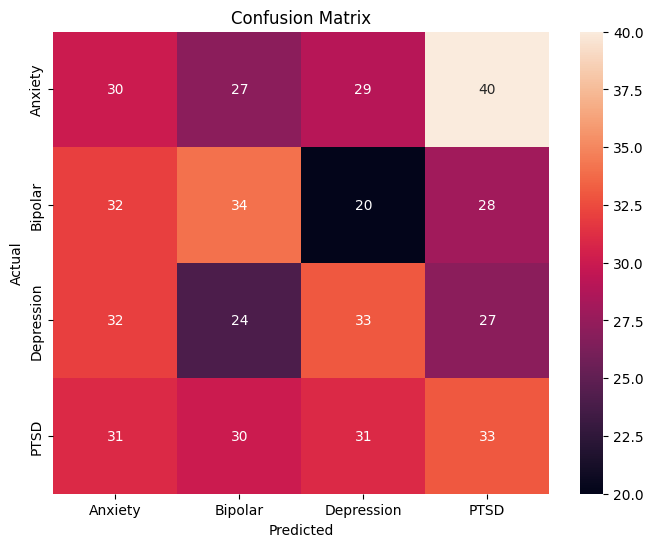


✅ Model, scaler, and encoder saved successfully.


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Split the cleaned dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Train LightGBM model
model = LGBMClassifier(random_state=42, objective='multiclass', num_class=len(np.unique(y)))
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("✅ Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save model artifacts
joblib.dump(model, "mh_lgbm_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("\n✅ Model, scaler, and encoder saved successfully.")


✅ Class distribution:
 Target
1    2405
0     100
Name: count, dtype: int64 

[LightGBM] [Info] Number of positive: 1683, number of negative: 1683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 3366, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Confusion Matrix:
[[ 30   0]
 [  2 720]]

✅ Classification Report:
               precision    recall  f1-score   support

 No Condition       0.94      1.00      0.97        30
Has Condition       1.00      1.00      1.00       722

     accuracy                           1.00       752
    macro avg       0.97      1.00      0.98       752
 weighted avg       1.00      1.00      1.00       752



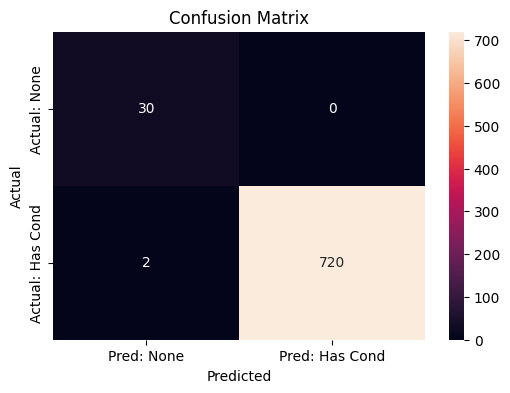


✅ Model and scaler saved successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load original dataset
df = pd.read_csv('/content/drive/MyDrive/Exercise-Recommender/new/mental/Mental_Health_Lifestyle_Dataset.csv')
df.drop(columns=["Country"], inplace=True)
df = df[df["Mental Health Condition"].notna()]

# Normalize target text
df["Mental Health Condition"] = df["Mental Health Condition"].astype(str).str.strip().str.lower()

# ✅ Create 100 synthetic 'none' cases
synthetic_none = pd.DataFrame({
    'Age': np.random.randint(18, 60, 100),
    'Gender': np.random.choice(['Male', 'Female', 'Other'], 100),
    'Exercise Level': np.random.choice(['Low', 'Moderate', 'Strong'], 100),
    'Diet Type': np.random.choice(['Balanced', 'Vegan', 'Vegetarian', 'Keto', 'Junk Food'], 100),
    'Sleep Hours': np.random.normal(7.5, 1, 100),
    'Stress Level': np.random.choice(['Low', 'Medium', 'High'], 100),
    'Work Hours per Week': np.random.randint(30, 50, 100),
    'Screen Time per Day (Hours)': np.random.uniform(1, 3, 100),
    'Social Interaction Score': np.random.uniform(6, 10, 100),
    'Happiness Score': np.random.uniform(7, 10, 100),
    'Mental Health Condition': ['none'] * 100
})

# Combine original and synthetic data
df = pd.concat([df, synthetic_none], ignore_index=True)

# Create binary target
df["Target"] = df["Mental Health Condition"].apply(lambda x: 0 if x == "none" else 1)

# Show distribution
print("✅ Class distribution:\n", df["Target"].value_counts(), "\n")

# Clip outliers
num_cols = ['Age', 'Sleep Hours', 'Work Hours per Week',
            'Screen Time per Day (Hours)', 'Social Interaction Score', 'Happiness Score']
for col in num_cols:
    Q1 = df[col].quantile(0.01)
    Q3 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], Q1, Q3)

# One-hot encoding
X = df.drop(columns=["Mental Health Condition", "Target"])
X = pd.get_dummies(X, drop_first=True)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Labels
y = df["Target"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# SMOTE balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train model
model = LGBMClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("✅ Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Condition", "Has Condition"]))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Pred: None", "Pred: Has Cond"],
            yticklabels=["Actual: None", "Actual: Has Cond"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model + scaler
model.feature_names = X.columns.tolist()
joblib.dump(model, "mh_binary_lgbm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\n✅ Model and scaler saved successfully.")


In [ ]:
# Show distribution
print("✅ Class distribution:\n", df["Target"].value_counts(), "\n")

✅ Class distribution:
 Target
1    2405
0     100
Name: count, dtype: int64 



In [ ]:
# Show distribution
print("✅ Class distribution:\n", df["Target"].value_counts(), "\n")
# %%
print("Shape of X_train_resampled:", X_train_resampled.shape)

# %%
import numpy as np

# Use np.unique to get the unique values and their counts in the numpy array
unique_classes, counts = np.unique(y_train_resampled, return_counts=True)

print("Class distribution in y_train_resampled:")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

✅ Class distribution:
 Target
1    2405
0     100
Name: count, dtype: int64 

Shape of X_train_resampled: (3366, 18)
Class distribution in y_train_resampled:
Class 0: 1683 samples
Class 1: 1683 samples


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import joblib
import pandas as pd

# Load model and scaler
model = joblib.load("mh_binary_lgbm_model.pkl")
scaler = joblib.load("scaler.pkl")

# Feature names from training
feature_names = model.feature_names

# Prediction function
def predict_mh(age, gender, exercise, diet, sleep, stress, work_hours, screen_time, social_score, happiness):
    # Construct input dictionary
    input_dict = {
        'Age': [age],
        'Sleep Hours': [sleep],
        'Work Hours per Week': [work_hours],
        'Screen Time per Day (Hours)': [screen_time],
        'Social Interaction Score': [social_score],
        'Happiness Score': [happiness],
        'Gender_Male': [1 if gender == "Male" else 0],
        'Gender_Other': [1 if gender == "Other" else 0],
        'Exercise Level_Low': [1 if exercise == "Low" else 0],
        'Exercise Level_Moderate': [1 if exercise == "Moderate" else 0],
        'Diet Type_Junk Food': [1 if diet == "Junk Food" else 0],
        'Diet Type_Keto': [1 if diet == "Keto" else 0],
        'Diet Type_Vegan': [1 if diet == "Vegan" else 0],
        'Diet Type_Vegetarian': [1 if diet == "Vegetarian" else 0],
        'Stress Level_Low': [1 if stress == "Low" else 0],
        'Stress Level_Moderate': [1 if stress == "Moderate" else 0],
    }

    # Fill missing columns with 0
    df_input = pd.DataFrame(input_dict)
    for col in feature_names:
        if col not in df_input.columns:
            df_input[col] = 0
    df_input = df_input[feature_names]

    # Scale and predict
    X_scaled = scaler.transform(df_input)
    prediction = model.predict(X_scaled)[0]
    return "🧠 At Risk of Mental Health Condition" if prediction == 1 else "✅ No Condition Detected"

# Gradio interface
iface = gr.Interface(
    fn=predict_mh,
    inputs=[
        gr.Slider(10, 100, label="Age"),
        gr.Radio(["Male", "Female", "Other"], label="Gender"),
        gr.Radio(["Low", "Moderate", "Strong"], label="Exercise Level"),
        gr.Radio(["Balanced", "Vegan", "Vegetarian", "Keto", "Junk Food"], label="Diet Type"),
        gr.Slider(0.0, 12.0, step=0.1, label="Sleep Hours"),
        gr.Radio(["Low", "Moderate", "High"], label="Stress Level"),
        gr.Slider(0, 100, step=1, label="Work Hours per Week"),
        gr.Slider(0.0, 24.0, step=0.1, label="Screen Time per Day (Hours)"),
        gr.Slider(0.0, 10.0, step=0.1, label="Social Interaction Score"),
        gr.Slider(0.0, 10.0, step=0.1, label="Happiness Score"),
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="🧠 MindBodyTrack AI",
    description="Predict mental health condition risk based on lifestyle habits. Ideal for individuals and gym owners."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://817211ec7d5e594873.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import joblib

# Load model
model = joblib.load("mh_binary_lgbm_model.pkl")

# Show feature names
print("🧠 Features used in the model:")
for feature in model.feature_names:
    print("-", feature)


🧠 Features used in the model:
- Age
- Sleep Hours
- Work Hours per Week
- Screen Time per Day (Hours)
- Social Interaction Score
- Happiness Score
- Gender_Male
- Gender_Other
- Exercise Level_Low
- Exercise Level_Moderate
- Exercise Level_Strong
- Diet Type_Junk Food
- Diet Type_Keto
- Diet Type_Vegan
- Diet Type_Vegetarian
- Stress Level_Low
- Stress Level_Medium
- Stress Level_Moderate


In [ ]:
# If label encoders exist
print("Exercise Prediction Report:")
print(classification_report(y_test_ex, pred_ex, target_names=ex_label_encoder.classes_))

print("Diet Prediction Report:")
print(classification_report(y_test_diet, pred_diet, target_names=diet_label_encoder.classes_))